In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import random
sns.set()
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
np.random.seed(1)
from calendar import monthrange
import random
import tensorflow as tf
np.random.seed(28)
random.seed(28)
tf.random.set_seed(28)

# Importante

Para las redes neuronales estamos usandos Keras, el cual requiere de tensorflow en el back para poder usarse. Antes de correr ciertos algoritmos se deberá tener configurado el entorno.


pip install keras

pip install tensorflow

pip install pmdarima


Primero leemos los dataset por separado. Luego pasamos a dividir el problema en 5 partes: La primera y segunda será sobre la demanda donde se estudiará el consumo total del pais por horas y luego por dias, la tercera y cuarta lo mismo pero con los datos de produccion y la quitan será buscar relacion entre la demanda y la produccion incluyendo eventos que afecten a estos datos. 
Ademas de varias modificaciones que se harán a los dataset con el fin de adaptarlo a cada parte

In [146]:
datosDemandaBruto = pd.read_csv("Demand13.csv")
datosProduccionBruto = pd.read_csv("Supply13.csv")

In [147]:
print(datosDemandaBruto)
datosDemandaBruto.head()

       Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1     3294   1243     757          488    471    598    525    514   
1          2     2973   1151     753          477    436    570    500    469   
2          3     2758   1105     727          471    419    604    478    430   
3          4     2703   1220     717          470    463    564    497    465   
4          5     2954   1358     751          519    515    626    553    517   
...      ...      ...    ...     ...          ...    ...    ...    ...    ...   
26347     20     4894   1906    1206         1008    912   1112   1112    914   
26348     21     4550   1798    1158          928    862   1047   1027    869   
26349     22     4326   1683    1091          868    818   1001    972    807   
26350     23     4090   1567     988          819    782    935    892    780   
26351     24     3954   1465     942          780    750    879    838    728   

       Najaf  Dywan.  Wasit

,Hours,Baghdad,Nynwa,Kirkuk,Slah El-Din,Anbar,Dyala,Babil,Kerb.,Najaf,Dywan.,Wasit,Muthnna,Thi-Qar,Mesan,Basrah
0,1,3294,1243,757,488,471,598,525,514,474,307,404,208,573,369,1254
1,2,2973,1151,753,477,436,570,500,469,437,284,374,193,536,342,1100
2,3,2758,1105,727,471,419,604,478,430,420,273,359,185,519,328,1056
3,4,2703,1220,717,470,463,564,497,465,451,301,397,204,522,363,1100
4,5,2954,1358,751,519,515,626,553,517,502,335,442,228,574,404,1298


In [148]:
print(datosProduccionBruto)
datosProduccionBruto.head()

       Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1   3294    740     668          488    394    598    525    514   
1          2   2973    751     753          477    387    570    500    469   
2          3   2758    760     727          471    374    604    478    430   
3          4   2703    759     717          470    365    546    490    433   
4          5   2794    727     751          470    374    578    539    472   
...      ...    ...    ...     ...          ...    ...    ...    ...    ...   
26347     20   3364    765     762          418    421    587    648    608   
26348     21   3437    748     751          412    418    617    678    638   
26349     22   3368    761     751          420    411    603    719    689   
26350     23   3373    801     782          424    406    614    663    681   
26351     24   3169    853     759          422    404    604    568    593   

       Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesa

,Hours,Bagh.,Nynwa,Kirkuk,Slah El-Din,Anbar,Dyala,Babil,Kerb.,Najaf,Dywan.,Wasit,Muthnna,Thi-Qar,Mesan,Basrah
0,1,3294,740,668,488,394,598,525,514,474,246,397,185,573,294,1104
1,2,2973,751,753,477,387,570,500,469,437,223,362,177,536,269,1030
2,3,2758,760,727,471,374,604,478,430,420,210,347,169,519,229,956
3,4,2703,759,717,470,365,546,490,433,420,202,350,172,522,232,953
4,5,2794,727,751,470,374,578,539,472,449,246,389,191,574,275,1003


Para el total de horas sumaremos el valor de todas las columna, ya que cada columna representa el valor de cada provincia, creando una nueva columna con esto mismo.

In [149]:
datosDemandaTotalHoras = pd.DataFrame()
datosProduccionTotalHoras = pd.DataFrame()

In [150]:
datosDemandaTotalHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [151]:
datosDemandaTotalHoras["Hours"] = datosDemandaBruto["Hours"]
datosProduccionTotalHoras["Hours"] = datosProduccionBruto["Hours"]

In [152]:
datosDemandaTotalSinHoras = pd.DataFrame()
datosProduccionTotalSinHoras = pd.DataFrame()

In [153]:
datosDemandaTotalSinHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalSinHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [154]:
datosDemandaTotalHoras.head()


,total,Hours
0,11479,1
1,10595,2
2,10132,3
3,10437,4
4,11576,5


In [155]:
datosDemandaTotalSinHoras.head()

,total
0,11479
1,10595
2,10132
3,10437
4,11576


Ahora partimos de un nuevo dataset el cual tiene una columna con las demanda/produccion por horas, es decir cada fila es una hora y cada 24 filas es un día. Una vez tenemos estos dos dataset, vamos a pasar estas horas a dias para tener los otros dos dataset faltantes.

In [156]:
suma_24_demanda = []
suma_24_produccion = []

In [157]:
for i in range(0, len(datosDemandaTotalSinHoras), 24):
    end = i + 24
    if end > len(datosDemandaTotalSinHoras):
        end = len(datosDemandaTotalSinHoras)
    suma_24_demanda.append(datosDemandaTotalSinHoras[i:end].sum(axis=0).sum())

In [158]:
for i in range(0, len(datosProduccionTotalSinHoras), 24):
    end = i + 24
    if end > len(datosProduccionTotalSinHoras):
        end = len(datosProduccionTotalSinHoras)
    suma_24_produccion.append(datosProduccionTotalSinHoras[i:end].sum(axis=0).sum())

In [159]:
datosDemandaTotalDias = pd.DataFrame({'Total': suma_24_demanda})
datosProduccionTotalDias = pd.DataFrame({'Total': suma_24_produccion})

In [160]:
diasDemanda = pd.date_range(start='2019-01-01', periods=len(suma_24_demanda), freq='D')
diasProduccion = pd.date_range(start='2019-01-01', periods=len(suma_24_produccion), freq='D')

In [161]:
datosDemandaTotalDias["fecha"] = diasDemanda
datosProduccionTotalDias["fecha"] = diasProduccion

Despues de hacer todas estas transformaciones ya tenemos los 4 dataset que queremos: datosDemandaTotalHoras/datosProduccionTotalHoras los cuales tiene la produccion total por ahora y datosDemandaTotalDias/datosProduccionTotalDias los cuales tienen la produccion por dias

In [162]:
datosDemandaTotalHoras.head()


,total,Hours
0,11479,1
1,10595,2
2,10132,3
3,10437,4
4,11576,5


In [163]:
datosProduccionTotalHoras.head()

,total,Hours
0,10494,1
1,9914,2
2,9452,3
3,9334,4
4,9832,5


In [166]:
datosHorariosDemanda = datosDemandaTotalHoras.rename(columns={'total': 'Demanda'})
datosHorariosDemanda

,Demanda,Hours
0,11479,1
1,10595,2
2,10132,3
3,10437,4
4,11576,5
...,...,...
26347,19725,20
26348,18376,21
26349,17323,22
26350,16220,23


In [167]:
datosHorariosProduccion = datosProduccionTotalHoras.rename(columns={'total': 'Produccion'})
datosHorariosProduccion

,Produccion,Hours
0,10494,1
1,9914,2
2,9452,3
3,9334,4
4,9832,5
...,...,...
26347,12754,20
26348,12639,21
26349,12320,22
26350,11802,23


In [173]:
datosHorariosProduccion['Demanda'] = datosHorariosDemanda['Demanda']
datosHorariosProduccion

,Produccion,Hours,Demanda
0,10494,1,11479
1,9914,2,10595
2,9452,3,10132
3,9334,4,10437
4,9832,5,11576
...,...,...,...
26347,12754,20,19725
26348,12639,21,18376
26349,12320,22,17323
26350,11802,23,16220


In [174]:
##datosHorariosProduccion.to_csv("datosHorarios.csv", index=False)

In [20]:
datosDemandaTotalDias.head()

,Total,fecha
0,379726,2019-01-01
1,383590,2019-01-02
2,378901,2019-01-03
3,378180,2019-01-04
4,385805,2019-01-05


In [21]:
datosProduccionTotalDias.head()

,Total,fecha
0,289005,2019-01-01
1,288843,2019-01-02
2,283581,2019-01-03
3,285621,2019-01-04
4,283991,2019-01-05


In [22]:
data = pd.merge(datosDemandaTotalDias, datosProduccionTotalDias, on='fecha')

In [23]:
data = data.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})

In [24]:
data = data.set_index('fecha')

In [25]:
data


,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-29,411592,261122
2021-12-30,378184,248905
2021-12-31,414996,257533


In [26]:
##data.to_csv("datosFinales.csv", index=False)

# Estudio de estaciones

In [28]:
estaciones = {
    1: 'Invierno',
    2: 'Invierno',
    3: 'Invierno',
    4: 'Primavera',
    5: 'Primavera',
    6: 'Verano',
    7: 'Verano',
    8: 'Verano',
    9: 'Verano',
    10: 'Otoño',
    11: 'Otoño',
    12: 'Invierno'
}

In [29]:
dataEstacion = data.copy()

In [30]:
dataEstacion['estacion'] = data.index.month.map(estaciones)

In [31]:
dataEstacion.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 2019-01-01 to 2022-01-02
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Demanda     1098 non-null   int64 
 1   Produccion  1098 non-null   int64 
 2   estacion    1098 non-null   object
dtypes: int64(2), object(1)
memory usage: 34.3+ KB


In [32]:
dataEstacion

,Demanda,Produccion,estacion
fecha,,,
2019-01-01,379726,289005,Invierno
2019-01-02,383590,288843,Invierno
2019-01-03,378901,283581,Invierno
2019-01-04,378180,285621,Invierno
2019-01-05,385805,283991,Invierno
...,...,...,...
2021-12-29,411592,261122,Invierno
2021-12-30,378184,248905,Invierno
2021-12-31,414996,257533,Invierno


In [33]:
dataEstacion.groupby(['estacion'])['Demanda'].mean()

estacion
Invierno     368132.762295
Otoño        342338.863388
Primavera    365714.278689
Verano       540844.855191
Name: Demanda, dtype: float64

In [34]:
dataEstacion.groupby(['estacion'])['Produccion'].mean()

estacion
Invierno     268142.710383
Otoño        283917.808743
Primavera    306742.420765
Verano       403776.814208
Name: Produccion, dtype: float64

<AxesSubplot:xlabel='fecha'>

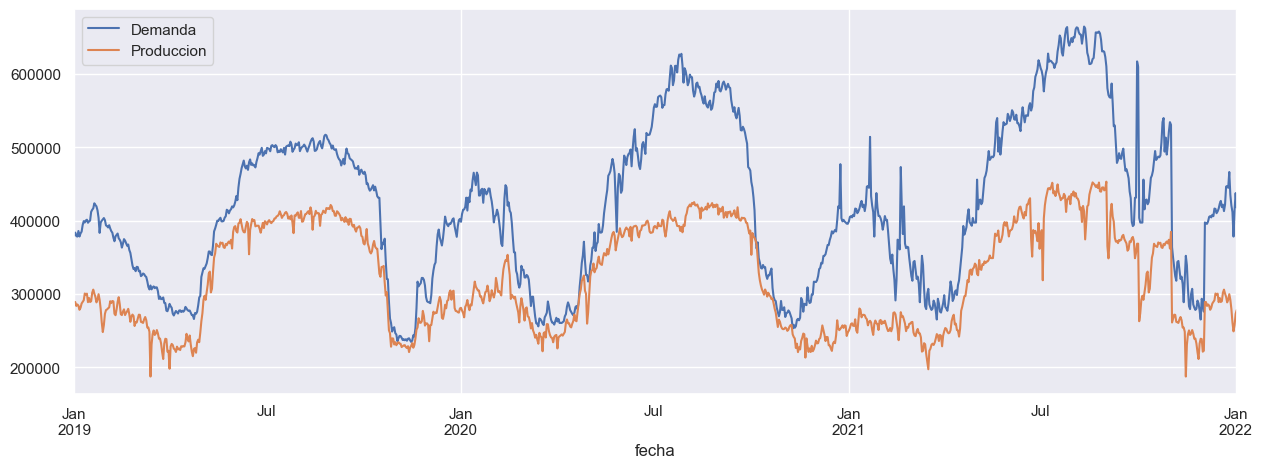

In [35]:
dataEstacion.plot(figsize=(15,5))

Ahora vamos a entrenar una red LSTM con los años 2019 y 2020 para ver si es capaz de predecir las estaciones en 2021
Para ello con convertiremos las etiquetas de estaciones del año a una forma numérica (codificación one-hot) para que el modelo pueda entenderlas.
Se va a probar con ventanas de 7,30,60,100,180 dias
Todo esto cogiendo una sola caracteristica luego, la realizaré con las dos para comparar resultados



In [36]:
data_final_2019_2020 = dataEstacion['2019':'2020']

In [37]:
data_final_2019_2020

,Demanda,Produccion,estacion
fecha,,,
2019-01-01,379726,289005,Invierno
2019-01-02,383590,288843,Invierno
2019-01-03,378901,283581,Invierno
2019-01-04,378180,285621,Invierno
2019-01-05,385805,283991,Invierno
...,...,...,...
2020-12-27,400978,253611,Invierno
2020-12-28,398717,257100,Invierno
2020-12-29,397432,256350,Invierno


In [38]:
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(data_final_2019_2020['estacion'].values.reshape(-1, 1))

In [39]:
def create_dataset_X(X, look_back=1):
    dataX = []
    for i in range(len(X) - look_back):
        dataX.append(X[i:(i + look_back)])
    return np.array(dataX)

def create_dataset_Y(Y, look_back=1):
    return Y[look_back:]

In [40]:
look_back = 180
X_data = create_dataset_X(data_final_2019_2020[['Demanda']].values, look_back)
Y_data = create_dataset_Y(y_encoded, look_back)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)


In [41]:
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)


Epoch 1/20
13/13 [==============================] - 6s 185ms/step - loss: 1.5567 - accuracy: 0.1117 - val_loss: 1.4927 - val_accuracy: 0.1084
Epoch 2/20
13/13 [==============================] - 1s 98ms/step - loss: 1.4888 - accuracy: 0.1117 - val_loss: 1.4361 - val_accuracy: 0.1084
Epoch 3/20
13/13 [==============================] - 1s 104ms/step - loss: 1.4354 - accuracy: 0.1169 - val_loss: 1.3963 - val_accuracy: 0.3193
Epoch 4/20
13/13 [==============================] - 1s 86ms/step - loss: 1.3965 - accuracy: 0.2597 - val_loss: 1.3636 - val_accuracy: 0.3193
Epoch 5/20
13/13 [==============================] - 1s 93ms/step - loss: 1.3698 - accuracy: 0.3247 - val_loss: 1.3443 - val_accuracy: 0.4157
Epoch 6/20
13/13 [==============================] - 2s 127ms/step - loss: 1.3495 - accuracy: 0.3792 - val_loss: 1.3272 - val_accuracy: 0.4157
Epoch 7/20
13/13 [==============================] - 2s 129ms/step - loss: 1.3388 - accuracy: 0.3792 - val_loss: 1.3207 - val_accuracy: 0.4157
Epoch 8/2

In [43]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

6/6 [==============================] - 1s 39ms/step


In [44]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 41.57%


In [45]:
print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))

              precision    recall  f1-score   support

    Invierno       0.00      0.00      0.00        53
       Otoño       0.00      0.00      0.00        26
   Primavera       0.00      0.00      0.00        18
      Verano       0.42      1.00      0.59        69

    accuracy                           0.42       166
   macro avg       0.10      0.25      0.15       166
weighted avg       0.17      0.42      0.24       166



Acurracy:  
7 días --> 32,56%  
30 dias --> 31.75%  
60 días--> 32.18%  
100 dias--> 34,21   
180 dias --> 41.57%  

Con dos caracteristicas


In [90]:
def create_multivariate_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        dataX.append(data[i:(i + look_back)])
        dataY.append(data[i + look_back, -4:])
    return np.array(dataX), np.array(dataY)

In [91]:
look_back = 180
data_for_lstm = pd.concat([data_final_2019_2020[['Produccion', 'Demanda']], pd.DataFrame(y_encoded, index=data_final_2019_2020.index)], axis=1).values
X_data, Y_data = create_multivariate_dataset(data_for_lstm, look_back)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)



In [92]:
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, X_data.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=32, verbose=1)

Epoch 1/30
13/13 [==============================] - 14s 665ms/step - loss: 1.3449 - accuracy: 0.2987 - val_loss: 1.2432 - val_accuracy: 0.4157
Epoch 2/30
13/13 [==============================] - 8s 557ms/step - loss: 1.1708 - accuracy: 0.4779 - val_loss: 1.0705 - val_accuracy: 0.5181
Epoch 3/30
13/13 [==============================] - 7s 558ms/step - loss: 1.0854 - accuracy: 0.5377 - val_loss: 0.9988 - val_accuracy: 0.5301
Epoch 4/30
13/13 [==============================] - 7s 538ms/step - loss: 1.0314 - accuracy: 0.5351 - val_loss: 0.9909 - val_accuracy: 0.5482
Epoch 5/30
13/13 [==============================] - 8s 609ms/step - loss: 1.0227 - accuracy: 0.4364 - val_loss: 0.9918 - val_accuracy: 0.4940
Epoch 6/30
13/13 [==============================] - 7s 566ms/step - loss: 0.9528 - accuracy: 0.5558 - val_loss: 1.0466 - val_accuracy: 0.4759
Epoch 7/30
13/13 [==============================] - 7s 554ms/step - loss: 0.9470 - accuracy: 0.5818 - val_loss: 1.1411 - val_accuracy: 0.4337
Epoch

In [94]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)



6/6 [==============================] - 4s 151ms/step


In [95]:
accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 42.17%


In [96]:
class_names = encoder.categories_[0].tolist()
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

    Invierno       1.00      0.02      0.04        53
       Otoño       0.00      0.00      0.00        26
   Primavera       0.00      0.00      0.00        18
      Verano       0.42      1.00      0.59        69

    accuracy                           0.42       166
   macro avg       0.35      0.25      0.16       166
weighted avg       0.49      0.42      0.26       166



Acurracy:  
7 días --> 24.77%  
30 dias --> 62.56%  
60 días--> 81.68%    
100 dias--> 50.53%     
180 dias --> 42.17% 

# Análisis



Ahora vamos a hacer transformaciones de estos dataset para sacar obtener el dataset final el cual tendrá las columnas de demanda y produccion, tambien cambiaremos el indice a la fecha para trabajar con las series temporales

In [98]:
data = data[data.index < pd.to_datetime("31-12-2021")]

In [99]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Demanda     1095 non-null   int64
 1   Produccion  1095 non-null   int64
dtypes: int64(2)
memory usage: 25.7 KB


,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-26,466243,299610
2021-12-27,435243,291977
2021-12-28,420410,279246


# Estudio Covid


In [100]:
dataPreCovid = data[data.index <= pd.to_datetime("23-feb-2020")]
dataPreCovid = dataPreCovid[pd.to_datetime("15-12-2019") <= dataPreCovid.index ]
dataPreCovid

,Demanda,Produccion
fecha,,
2019-12-15,375697,265910
2019-12-16,389443,272995
2019-12-17,405381,285184
2019-12-18,398381,280298
2019-12-19,394335,290496
...,...,...
2020-02-19,375118,296528
2020-02-20,356693,293828
2020-02-21,356625,296104


<AxesSubplot:xlabel='fecha'>

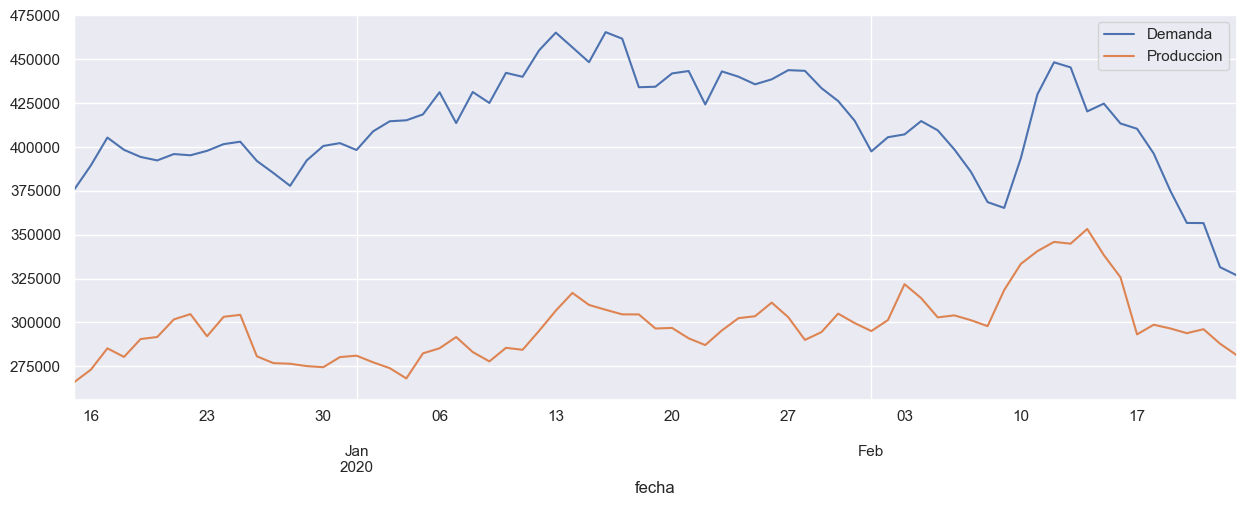

In [101]:
dataPreCovid.plot(figsize=(15,5))

In [102]:
dataCovid = data[data.index <= pd.to_datetime("30-04-2020")].copy()
dataCovid = dataCovid[pd.to_datetime("24-02-2020") <= dataCovid.index ]
dataCovid

,Demanda,Produccion
fecha,,
2020-02-24,314394,274931
2020-02-25,308539,261047
2020-02-26,313477,282819
2020-02-27,338249,294075
2020-02-28,332861,286547
...,...,...
2020-04-26,371136,325099
2020-04-27,344921,304380
2020-04-28,325709,300122


<AxesSubplot:xlabel='fecha'>

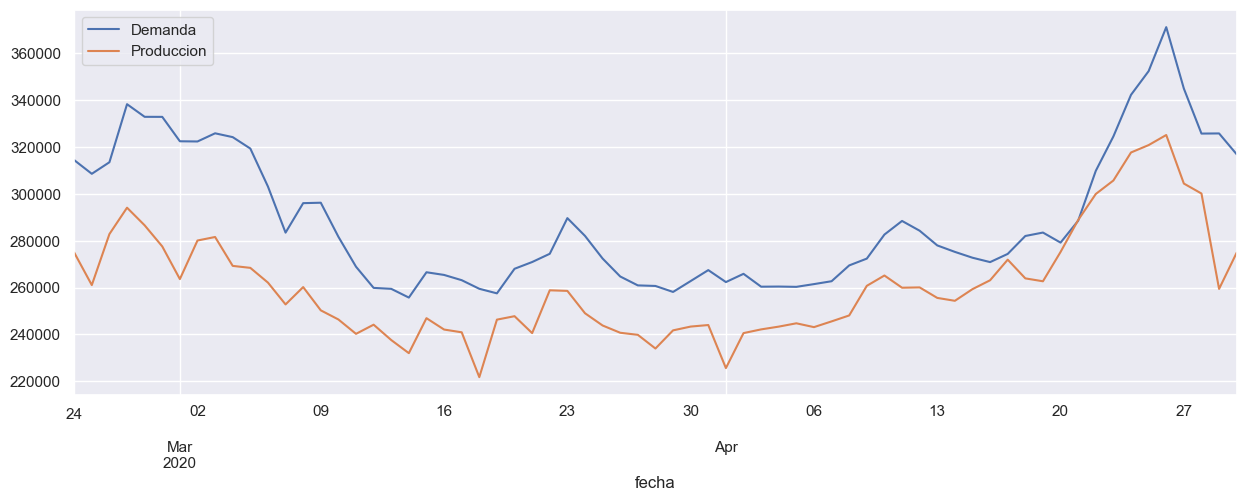

In [103]:
dataCovid.plot(figsize=(15,5))

In [104]:
media_Covid_precovid = pd.DataFrame() 
datosCovid = {'Periodo': ['Pre-Covid','Covid principio'],
        'Media demanda': [dataPreCovid['Demanda'].mean(), dataCovid['Demanda'].mean()],
        'Media produccion': [dataPreCovid['Produccion'].mean(), dataCovid['Produccion'].mean()]}

media_Covid_precovid = pd.DataFrame(datosCovid)
media_Covid_precovid = media_Covid_precovid.set_index('Periodo')
media_Covid_precovid

,Media demanda,Media produccion
Periodo,,
Pre-Covid,412271.957746,297922.295775
Covid principio,288816.000000,261000.223881


Text(0, 0.5, 'Cuantidad')

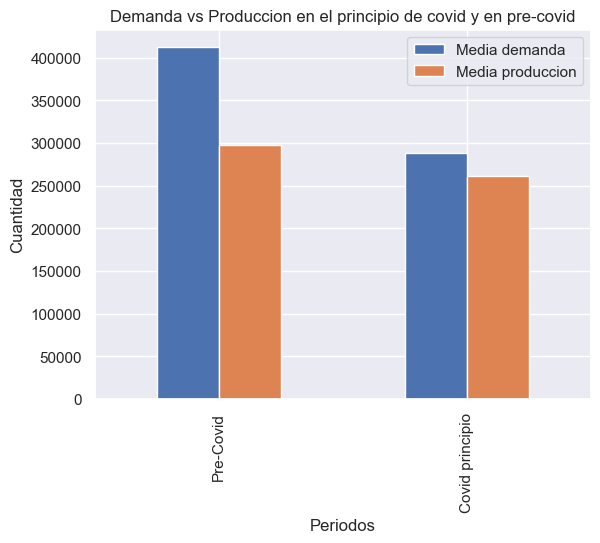

In [105]:
media_Covid_precovid.plot(kind="bar")
plt.title("Demanda vs Produccion en el principio de covid y en pre-covid")
plt.xlabel("Periodos")
plt.ylabel("Cuantidad")

# Festivo nacionales 

In [129]:
# Lista de días festivos
festivos = ["01-jan-2019", "06-jan-2019", "01-may-2019", "14-jul-2019", "03-oct-2019",
            "01-jan-2020", "06-jan-2020", "01-may-2020", "14-jul-2020", "03-oct-2020",
            "01-jan-2021", "06-jan-2021", "01-may-2021", "14-jul-2021", "03-oct-2021"]

# Crear una columna 'Festivo_Nacional' en el DataFrame
data['Festivo_Nacional'] = data.index.isin(festivos).astype(int)



In [130]:
data

,Demanda,Produccion,Festivo_Nacional
fecha,,,
2019-01-01,379726,289005,1
2019-01-02,383590,288843,0
2019-01-03,378901,283581,0
2019-01-04,378180,285621,0
2019-01-05,385805,283991,0
...,...,...,...
2021-12-26,466243,299610,0
2021-12-27,435243,291977,0
2021-12-28,420410,279246,0


In [133]:
# Extraer características y etiquetas
features = data[['Demanda']].values
labels = data['Festivo_Nacional'].values

# Escalar las características
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Función para crear conjuntos de datos con pasos temporales para LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 180
X, y = create_dataset(scaled_features, labels, TIME_STEPS)

# Crea una nueva máscara booleana para las fechas que han sido transformadas
mask_train = data.index[TIME_STEPS:].year < 2021
mask_test = (data.index[TIME_STEPS:].year == 2021) & (data['Festivo_Nacional'][TIME_STEPS:] == 1)

# Usa esta nueva máscara para dividir los datos
X_train, y_train = X[mask_train], y[mask_train]
X_test, y_test = X[mask_test], y[mask_test]

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=False, batch_size=32, verbose=1)


Epoch 1/20
18/18 [==============================] - 5s 154ms/step - loss: 0.5138 - accuracy: 0.9873 - val_loss: 2.1340 - val_accuracy: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 2s 131ms/step - loss: 0.0744 - accuracy: 0.9873 - val_loss: 4.6239 - val_accuracy: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 2s 130ms/step - loss: 0.0688 - accuracy: 0.9873 - val_loss: 4.6676 - val_accuracy: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 2s 129ms/step - loss: 0.0687 - accuracy: 0.9873 - val_loss: 4.4798 - val_accuracy: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 2s 132ms/step - loss: 0.0683 - accuracy: 0.9873 - val_loss: 4.3993 - val_accuracy: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 2s 128ms/step - loss: 0.0682 - accuracy: 0.9873 - val_loss: 4.3974 - val_accuracy: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 2s 127ms/step - loss: 0.0682 - accuracy: 0.9873 - val_loss: 4.4087 - val

In [136]:
# Extraer características y etiquetas
features = data[['Produccion','Demanda']].values
labels = data['Festivo_Nacional'].values

# Escalar las características
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Función para crear conjuntos de datos con pasos temporales para LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 180
X, y = create_dataset(scaled_features, labels, TIME_STEPS)

# Crea una nueva máscara booleana para las fechas que han sido transformadas
mask_train = data.index[TIME_STEPS:].year < 2021
mask_test = (data.index[TIME_STEPS:].year == 2021) & (data['Festivo_Nacional'][TIME_STEPS:] == 1)

# Usa esta nueva máscara para dividir los datos
X_train, y_train = X[mask_train], y[mask_train]
X_test, y_test = X[mask_test], y[mask_test]

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=False, batch_size=32, verbose=1)


Epoch 1/20
18/18 [==============================] - 6s 172ms/step - loss: 0.5636 - accuracy: 0.8748 - val_loss: 1.4327 - val_accuracy: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 3s 142ms/step - loss: 0.1062 - accuracy: 0.9873 - val_loss: 4.4725 - val_accuracy: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 3s 149ms/step - loss: 0.0686 - accuracy: 0.9873 - val_loss: 4.7467 - val_accuracy: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 3s 137ms/step - loss: 0.0690 - accuracy: 0.9873 - val_loss: 4.5387 - val_accuracy: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 3s 148ms/step - loss: 0.0685 - accuracy: 0.9873 - val_loss: 4.4142 - val_accuracy: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 3s 143ms/step - loss: 0.0683 - accuracy: 0.9873 - val_loss: 4.3980 - val_accuracy: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 3s 148ms/step - loss: 0.0682 - accuracy: 0.9873 - val_loss: 4.4115 - val

In [134]:
# Predicciones
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Mostrar resultados
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))



1/1 [==============================] - 0s 452ms/step
Accuracy: 0.00%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       5.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



Como vemos el modelo no consigue acerta ningun dia

In [106]:
Festivos_Nacionales = ["01-jan-2019" ,"06-jan-2019","01-may-2019","14-jul-2019","03-oct-2019","01-jan-2020" ,"06-jan-2020","01-may-2020","14-jul-2020","03-oct-2020","01-jan-2021" ,"06-jan-2021","01-may-2021","14-jul-2021","03-oct-2021"]
Festivos_Nacionales


['01-jan-2019',
 '06-jan-2019',
 '01-may-2019',
 '14-jul-2019',
 '03-oct-2019',
 '01-jan-2020',
 '06-jan-2020',
 '01-may-2020',
 '14-jul-2020',
 '03-oct-2020',
 '01-jan-2021',
 '06-jan-2021',
 '01-may-2021',
 '14-jul-2021',
 '03-oct-2021']

In [107]:
dataFestivo = data[data.index.isin(Festivos_Nacionales)]
dataFestivo


,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-06,378280,278314
2019-05-01,323099,262720
2019-07-14,493512,412650
2019-10-03,461922,375271
2020-01-01,398283,281007
2020-01-06,431218,285232
2020-05-01,320559,299753
2020-07-14,579399,400581


<AxesSubplot:xlabel='fecha'>

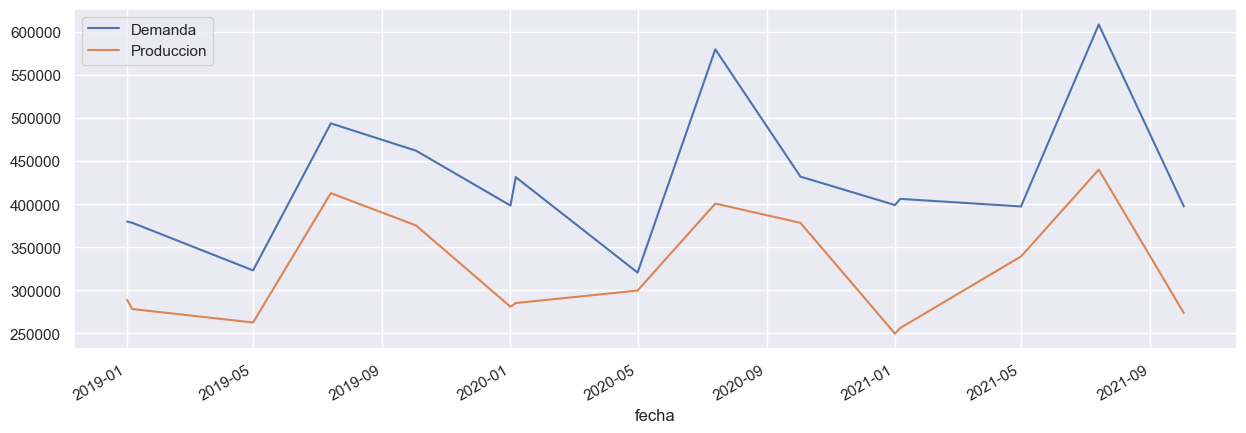

In [108]:
dataFestivo.plot(figsize=(15,5))

Text(0, 0.5, 'Cuantidad')

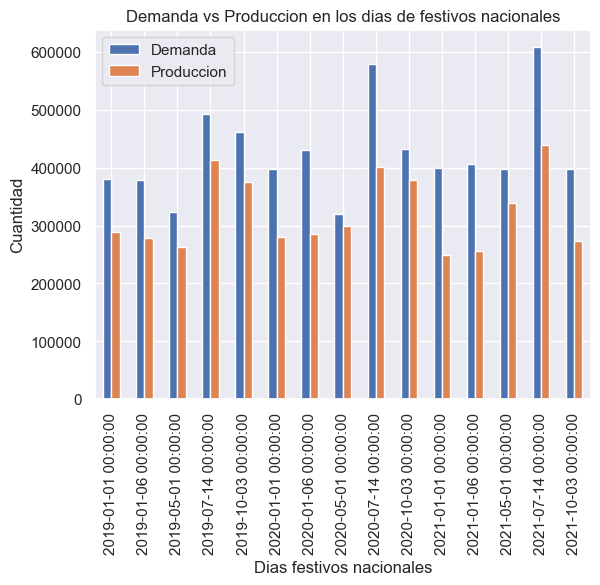

In [109]:
dataFestivo.plot(kind="bar")
plt.title("Demanda vs Produccion en los dias de festivos nacionales")
plt.xlabel("Dias festivos nacionales")
plt.ylabel("Cuantidad")

In [110]:
dataTemporadasProduccion = dataEstacion.groupby('estacion').agg(media_produccion=('Produccion','mean')).reset_index()
dataTemporadasProduccion

,estacion,media_produccion
0,Invierno,268142.710383
1,Otoño,283917.808743
2,Primavera,306742.420765
3,Verano,403776.814208


In [111]:
dataTemporadasDemanda = dataEstacion.groupby('estacion').agg(media_Demanda=('Demanda','mean')).reset_index()
dataTemporadasDemanda

,estacion,media_Demanda
0,Invierno,368132.762295
1,Otoño,342338.863388
2,Primavera,365714.278689
3,Verano,540844.855191


In [112]:
dataTemporadas = pd.merge(dataTemporadasDemanda, dataTemporadasProduccion, on='estacion')
dataTemporadas = dataTemporadas.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})
dataTemporadas = dataTemporadas.set_index('estacion')
dataTemporadas

,media_Demanda,media_produccion
estacion,,
Invierno,368132.762295,268142.710383
Otoño,342338.863388,283917.808743
Primavera,365714.278689,306742.420765
Verano,540844.855191,403776.814208


Text(0, 0.5, 'Capacidad media')

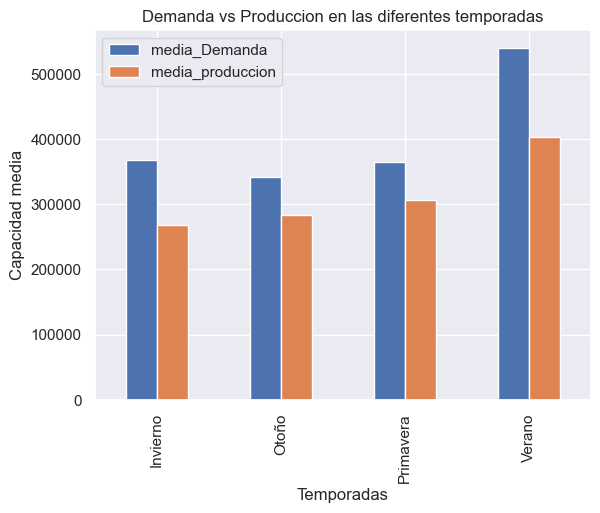

In [113]:
dataTemporadas.plot(kind="bar")
plt.title("Demanda vs Produccion en las diferentes temporadas")
plt.xlabel("Temporadas")
plt.ylabel("Capacidad media")

# Shaaban vs  Ramadan

In [19]:
data_shaaban_ramadan = pd.read_csv("datosFinales.csv")

In [20]:
data_shaaban_ramadan

,Demanda,Produccion
0,379726,289005
1,383590,288843
2,378901,283581
3,378180,285621
4,385805,283991
...,...,...
1093,411592,261122
1094,378184,248905
1095,414996,257533
1096,437452,272710


In [21]:
date_index = pd.date_range(start="01-01-2019", periods=len(data_shaaban_ramadan), freq='D')
data_shaaban_ramadan.index = date_index

In [23]:
data_shaaban_ramadan

,Demanda,Produccion
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-29,411592,261122
2021-12-30,378184,248905
2021-12-31,414996,257533
2022-01-01,437452,272710


In [24]:
labels = pd.Series(0, index=data_shaaban_ramadan.index)
labels[(pd.to_datetime("06-may-2019") <= labels.index) & (labels.index <= pd.to_datetime("04-jun-2019"))] = 1
labels[(pd.to_datetime("06-apr-2019") <= labels.index) & (labels.index <= pd.to_datetime("05-may-2019"))] = 1
labels[(pd.to_datetime("24-apr-2020") <= labels.index) & (labels.index <= pd.to_datetime("23-may-2020"))] = 1
labels[(pd.to_datetime("25-mar-2020") <= labels.index) & (labels.index <= pd.to_datetime("23-apr-2020"))] = 1
labels[(pd.to_datetime("13-apr-2021") <= labels.index) & (labels.index <= pd.to_datetime("12-may-2021"))] = 1
labels[(pd.to_datetime("14-mar-2021") <= labels.index) & (labels.index <= pd.to_datetime("12-apr-2021"))] = 1
data_shaaban_ramadan['label'] = labels

In [34]:
features = ['Demanda', 'Produccion', 'label']
train_data = data_shaaban_ramadan[features]['2019-01-01':'2020-12-31']
valid_data = data_shaaban_ramadan[features]['2021-01-01':]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)

In [40]:

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :-1])
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

In [45]:
look_back = 60
X_train, y_train = create_dataset(train_scaled, look_back)
X_valid, y_valid = create_dataset(valid_scaled, look_back)

In [46]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

Epoch 1/50
21/21 - 8s - loss: 0.5384 - accuracy: 0.7601 - val_loss: 0.4049 - val_accuracy: 0.8046 - 8s/epoch - 398ms/step
Epoch 2/50
21/21 - 1s - loss: 0.4319 - accuracy: 0.8212 - val_loss: 0.3691 - val_accuracy: 0.8046 - 1s/epoch - 61ms/step
Epoch 3/50
21/21 - 1s - loss: 0.3913 - accuracy: 0.8212 - val_loss: 0.3319 - val_accuracy: 0.8046 - 1s/epoch - 62ms/step
Epoch 4/50
21/21 - 1s - loss: 0.3663 - accuracy: 0.8212 - val_loss: 0.2741 - val_accuracy: 0.8046 - 1s/epoch - 56ms/step
Epoch 5/50
21/21 - 1s - loss: 0.3553 - accuracy: 0.8212 - val_loss: 0.3036 - val_accuracy: 0.8046 - 1s/epoch - 57ms/step
Epoch 6/50
21/21 - 1s - loss: 0.3371 - accuracy: 0.8137 - val_loss: 0.4011 - val_accuracy: 0.8046 - 1s/epoch - 56ms/step
Epoch 7/50
21/21 - 1s - loss: 0.3201 - accuracy: 0.8331 - val_loss: 0.2332 - val_accuracy: 0.8046 - 1s/epoch - 56ms/step
Epoch 8/50
21/21 - 1s - loss: 0.3046 - accuracy: 0.8152 - val_loss: 0.2384 - val_accuracy: 0.8958 - 1s/epoch - 56ms/step
Epoch 9/50
21/21 - 1s - loss: 0

In [47]:
y_pred_probs = model.predict(X_valid)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

10/10 [==============================] - 1s 23ms/step


In [48]:
real_days = y_valid[y_valid == 1]
predicted_days = y_pred[y_valid == 1]

# Calcular y mostrar la precisión
accuracy = accuracy_score(real_days, predicted_days)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Mostrar el informe de clasificación
report = classification_report(real_days, predicted_days)
print(report)

Accuracy: 0.00%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      60.0

    accuracy                           0.00      60.0
   macro avg       0.00      0.00      0.00      60.0
weighted avg       0.00      0.00      0.00      60.0



In [50]:
#2019
dataRamadan2019 = data[pd.to_datetime("06-may-2019") <= data.index ]
dataRamadan2019  = dataRamadan2019[dataRamadan2019.index <= pd.to_datetime("04-jun-2019")]

dataShaaban2019 = data[pd.to_datetime("06-apr-2019") <= data.index ]
dataShaaban2019  = dataShaaban2019[dataShaaban2019.index <= pd.to_datetime("05-may-2019")]

#2020
dataRamadan2020 = data[pd.to_datetime("24-apr-2020") <= data.index ]
dataRamadan2020  = dataRamadan2020[dataRamadan2020.index <= pd.to_datetime("23-may-2020")]

dataShaaban2020 = data[pd.to_datetime("25-mar-2020") <= data.index ]
dataShaaban2020  = dataShaaban2020[dataShaaban2020.index <= pd.to_datetime("23-apr-2020")]

#2021
dataRamadan2021 = data[pd.to_datetime("13-apr-2021") <= data.index ]
dataRamadan2021  = dataRamadan2021[dataRamadan2021.index <= pd.to_datetime("12-may-2021")]

dataShaaban2021 = data[pd.to_datetime("14-mar-2021") <= data.index ]
dataShaaban2021  = dataShaaban2021[dataShaaban2021.index <= pd.to_datetime("12-apr-2021")]


In [51]:
media_Chaaban_Ramadan = pd.DataFrame() 
datos = {'Mes_hijri': ['Shaaban 2019','Ramadan 2019' ,'Shaaban 2020','Ramadan 2020', 'Shaaban 2021','Ramadan 2021'],
        'Media demanda': [dataShaaban2019['Demanda'].mean(), dataRamadan2019['Demanda'].mean(), dataShaaban2020['Demanda'].mean(), dataRamadan2020['Demanda'].mean(), dataShaaban2021['Demanda'].mean(),dataRamadan2021['Demanda'].mean()],
        'Media produccion': [dataShaaban2019['Produccion'].mean(), dataRamadan2019['Produccion'].mean(), dataShaaban2020['Produccion'].mean(), dataRamadan2020['Produccion'].mean(), dataShaaban2021['Produccion'].mean(),dataRamadan2021['Produccion'].mean()]}

media_Shaaban_Ramadan = pd.DataFrame(datos)
media_Shaaban_Ramadan = media_Shaaban_Ramadan.set_index('Mes_hijri')
media_Shaaban_Ramadan

,Media demanda,Media produccion
Mes_hijri,,
Shaaban 2019,286469.000000,238806.866667
Ramadan 2019,395727.033333,357752.066667
Shaaban 2020,273865.533333,255552.966667
Ramadan 2020,386320.000000,335347.600000
Shaaban 2021,288550.200000,240607.533333
Ramadan 2021,400432.066667,314738.500000


Text(0, 0.5, 'Media')

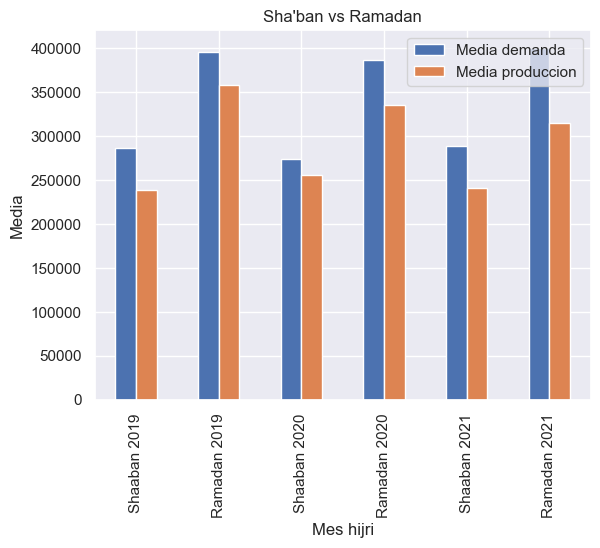

In [52]:
media_Shaaban_Ramadan.plot(kind="bar")
plt.title("Sha'ban vs Ramadan")
plt.xlabel("Mes hijri")
plt.ylabel("Media")

In [53]:
data.describe()

,Demanda,Produccion
count,1095.000000,1095.000000
mean,420994.799087,322561.829224
std,108713.245473,69567.326734
min,234522.000000,187266.000000
25%,325740.000000,258997.500000
50%,411592.000000,303169.000000
75%,498163.500000,391964.000000
max,664606.000000,453020.000000


Ya de primera podemos observar que vamos a tener dias donde la demanda supera a la produccion, y ademas de media siempre vamos a tener mayor demanda que produccion

In [54]:
dataMes= data.resample('m').sum()
dataMes

,Demanda,Produccion
fecha,,
2019-01-31,12344034,8892026
2019-02-28,10327355,7753904
2019-03-31,9566047,7603419
2019-04-30,8329040,6860510
2019-05-31,11823599,10597214
2019-06-30,14146614,11740792
2019-07-31,15465729,12511220
2019-08-31,15627938,12676743
2019-09-30,14477503,11977411


In [55]:
dataAno = data.resample('y').sum()
dataAno

,Demanda,Produccion
fecha,,
2019-12-31,143314874,116508462
2020-12-31,152389040,117898414
2021-12-31,165285391,118798327


<AxesSubplot:xlabel='fecha'>

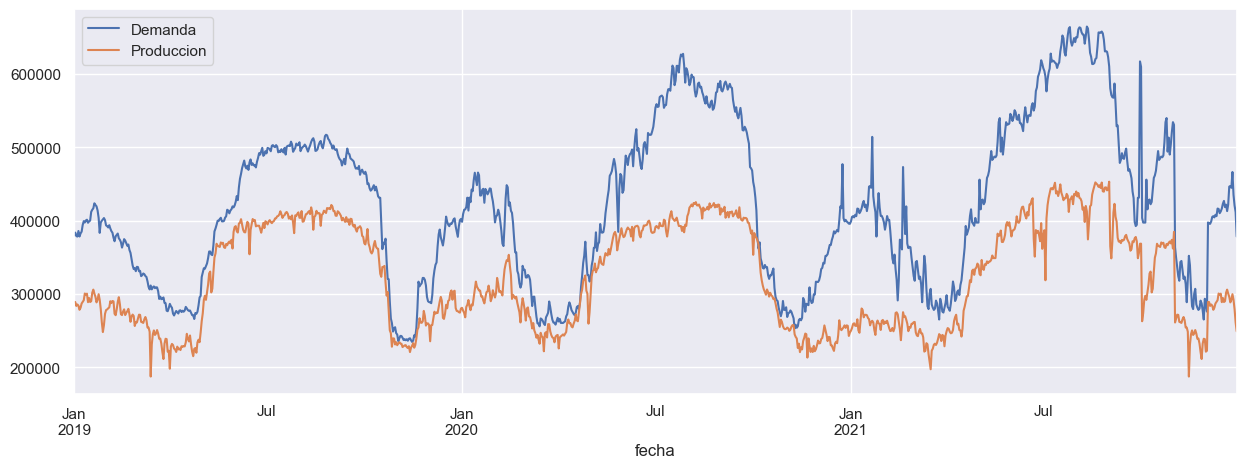

In [56]:
data.plot(figsize=(15,5))

<AxesSubplot:>

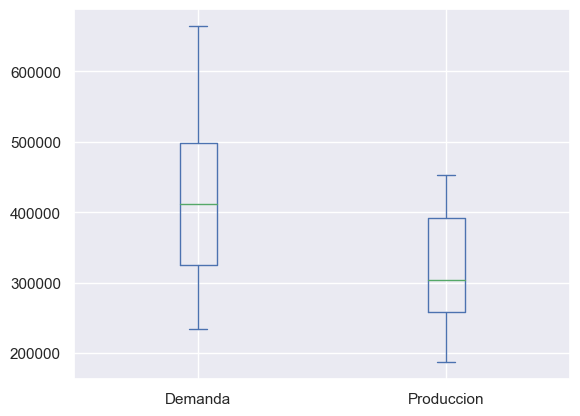

In [57]:
data.plot.box()

Vemos que la produccion nunca abaste la demanda, ademas nos fijamos que en los meses de verano siempre tenemos un pico de demanda que ademas aumenta con los años mientras que la produccion de mantiene

# Dickey-fuller

Vamos a pasar a comprobar si nuestra serie de tiempo es estacionario o no. Para ello vamos a seguir el modelo Dickey-Fuller

In [58]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviacion estandar')
    plt.legend(loc='best')
    plt.title('Media móvil & Desviacion estandar')
    plt.show(block=False)
    
    print ('Resultados del Dickey-Fuller Test:')
   
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de prueba','p-value','#Lags Used','Numero de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valores criticos (%s)'%key] = value
    print(dfoutput)

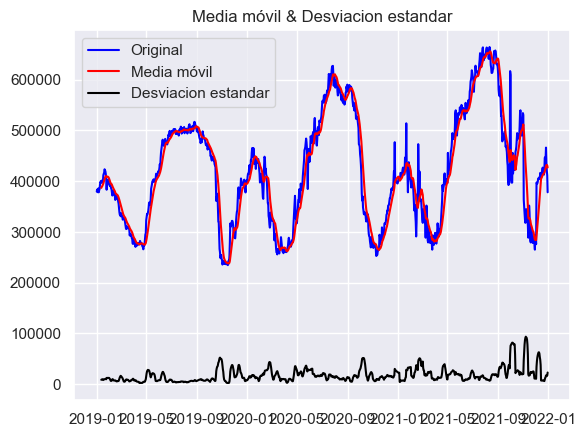

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -3.080073
p-value                       0.028063
#Lags Used                   16.000000
Numero de observaciones    1078.000000
Valores criticos (1%)        -3.436431
Valores criticos (5%)        -2.864225
Valores criticos (10%)       -2.568200
dtype: float64


In [59]:
adfullerDemanda = test_stationarity(data['Demanda'])

Según estos resultados vemos observamos que podemos afirmar que al demanda es estacionario por diversos motivos, el p-value nos indica que tenemos una probabilidad muy baja del 2.68% de que los resultados observados en la serie de tiempo se deban al azar que nos indica que podemos rechazar la hipotesis nula. Luego el estadístico de prueba es menor que los valores críticos para los niveles de significación de 1% y 5% y no difiere mucho del 10% por lo que volvemos a rechazar la hipotesis nula. 

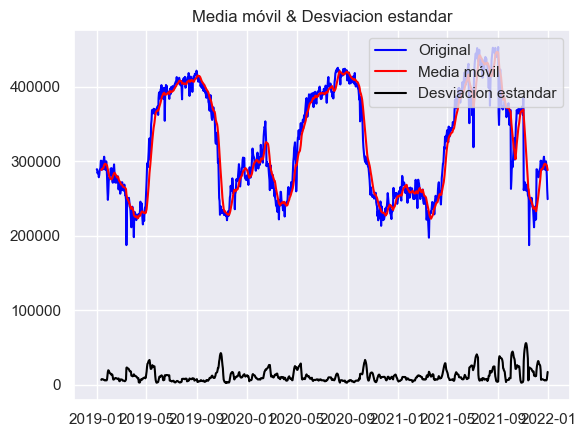

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -2.022303
p-value                       0.276880
#Lags Used                    4.000000
Numero de observaciones    1090.000000
Valores criticos (1%)        -3.436364
Valores criticos (5%)        -2.864195
Valores criticos (10%)       -2.568184
dtype: float64


In [60]:
adfullerProduccion = test_stationarity(data['Produccion'])

Con la produccion vemos que ocurre todo lo contrario, el p-value es mayor que el valor de significancia del 0,05 y ademas nuestro estadistico de prueba es mayor que todos los valores criticos. Por lo cual decidimos que la serie de tiempo no es estacionaria.

## ARIMA

Sabiendo que la demanda si es estacionaria, vamos a aplicarle un modelo de  regresion autorregresiva integrada de media movil (ARIMA)

In [61]:
dataArima= dataMes['Demanda'].copy()


In [62]:
train_data_arima = dataArima[:int(len(dataArima)*0.8)].copy()
test_data_arima = dataArima[int(len(dataArima)*0.8):].copy()


In [63]:
def modelo_arima(p,d,q):
    model = ARIMA(train_data_arima, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())

In [64]:
modelo_arima(1,1,1)
modelo_arima(2,1,1)
modelo_arima(2,1,2)


                               SARIMAX Results                                
Dep. Variable:                Demanda   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -436.052
Date:                Thu, 24 Aug 2023   AIC                            878.104
Time:                        18:38:49   BIC                            881.991
Sample:                    01-31-2019   HQIC                           879.260
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      1.231     -0.177      0.860      -2.631       2.196
ma.L1          0.3382      1.249      0.271      0.787      -2.109       2.786
sigma2      5.968e+12   4.28e-13   1.39e+25      0.0

Vamos a probar con una funcion que nos saca lo mejores valores

Vemos que el mejor AIC lo tiene el modelo para los valores (2,1,2)

In [65]:
modelfinal = ARIMA(train_data_arima, order=(2, 1, 2))
model_fit1 = modelfinal.fit()

In [66]:
forecast = model_fit1.forecast(steps=10)[0]

In [67]:
print(forecast)

11083109.210077316


In [68]:
predicciones = model_fit1.predict(start=len(train_data_arima), end=len(dataArima)-1, typ='levels')
predicciones

2021-05-31    1.108311e+07
2021-06-30    1.302891e+07
2021-07-31    1.414135e+07
2021-08-31    1.331579e+07
2021-09-30    1.140824e+07
2021-10-31    1.034849e+07
2021-11-30    1.118810e+07
2021-12-31    1.305750e+07
Freq: M, Name: predicted_mean, dtype: float64

In [69]:
errorARIMA = np.mean(np.abs((test_data_arima - predicciones) / test_data_arima)) * 100
accuracyARIMA = 100 - errorARIMA
mseARIMA = mean_squared_error(test_data_arima, predicciones)

In [70]:
print(f"Precision modelo ARIMA es: {accuracyARIMA}" )
print(f"El error es: {errorARIMA}")
print(f"El error cuadrático mse: {mseARIMA} kw")

Precision modelo ARIMA es: 76.83425210441922
El error es: 23.16574789558078
El error cuadrático mse: 16757269390052.26 kw


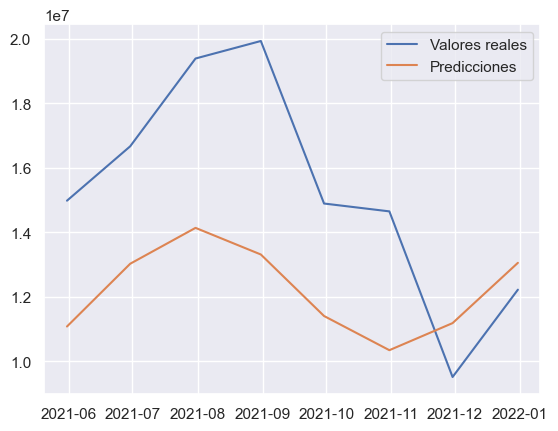

In [71]:
plt.plot(dataArima.index[int(len(dataArima)*0.8):], test_data_arima, label='Valores reales')
plt.plot(dataArima.index[int(len(dataArima)*0.8):], predicciones, label='Predicciones')
plt.legend()
plt.show()

# RNN por días 

Estudiando un poco la relación que existe entre la demanda y la produccion encontramos que esta última siempre va a estar condicionada por la demanda ya que no se puede dar el caso de que la produccion sea mayor que la demanda. Vamos a aplicar un modelo de Deep learning conocido como Redes neuronales recurrentes(RNN), las cuales cuentan con "memoria". Usaremos de tipo LSTM, con dos capas LSTM de 50 unidades, una Dense con una única salida y el optimizador Adam, que para este tipo de series temporales es el mas adecuado

In [50]:
dataRNNdias = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdias), freq='D')
dataRNNdias.index = date_index

In [52]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataRNNdias['Demanda'] = scaler.fit_transform(dataRNNdias[['Demanda']])
dataRNNdias['Produccion'] = scaler.fit_transform(dataRNNdias[['Produccion']])
timesteps = 30

In [53]:
x = []
y = []
for i in range(timesteps, len(dataRNNdias)):
    x.append(dataRNNdias[i-timesteps:i][['Demanda', 'Produccion']].values)
    y.append(dataRNNdias['Produccion'][i])

In [54]:
x = np.array(x)
y = np.array(y)

In [55]:
train_size = int(len(dataRNNdias) * 0.7)
x_train = x[:train_size, :, :]
y_train = y[:train_size]
x_test = x[train_size:, :, :]
y_test = y[train_size:]

In [56]:
modelo = Sequential()
modelo.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
modelo.add(LSTM(50))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

In [57]:
modelo.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

In [58]:
y_pred = modelo.predict(x_test)

10/10 [==============================] - 1s 14ms/step


In [59]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [60]:
y_pred

array([[246027.81],
       [242561.88],
       [241755.45],
       [232666.89],
       [228641.27],
       [230381.  ],
       [228544.73],
       [220836.11],
       [214904.03],
       [207714.94],
       [215937.83],
       [220942.77],
       [225414.2 ],
       [227988.17],
       [228704.39],
       [230101.66],
       [232927.33],
       [236883.33],
       [240550.47],
       [236523.98],
       [239334.52],
       [240241.58],
       [233309.53],
       [240679.17],
       [248116.45],
       [251414.83],
       [251577.17],
       [248908.1 ],
       [248237.27],
       [250096.97],
       [254498.7 ],
       [262231.47],
       [265727.66],
       [269134.22],
       [262025.8 ],
       [261263.9 ],
       [255108.89],
       [254939.31],
       [250164.14],
       [257316.7 ],
       [276136.47],
       [284702.12],
       [292560.22],
       [295439.53],
       [295645.2 ],
       [303405.38],
       [314754.03],
       [314932.7 ],
       [325167.84],
       [328245.1 ],


In [61]:
errorRNND = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracyRNND  = 100 - errorRNND 
mseRNND  = np.mean((y_pred - y_test)**2)

In [62]:
print(f"Precision de la RNN por días es: {accuracyRNND}" )
print(f"El error es: {errorRNND}")
print(f"El error cuadrático mse: {mseRNND} kw")

Precision de la RNN por días es: 96.81079195051458
El error es: 3.189208049485416
El error cuadrático mse: 298369464.47851235 kw


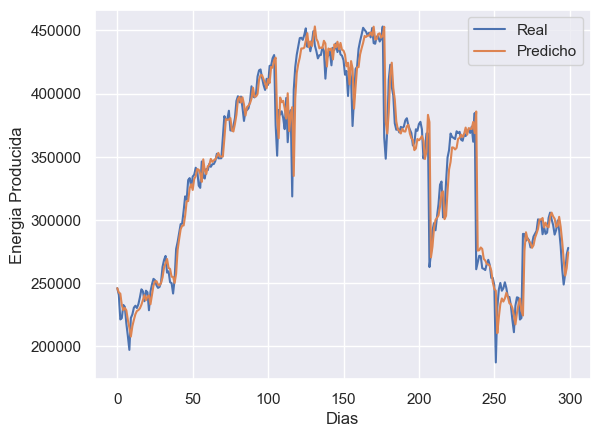

In [63]:
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Dias')
plt.ylabel('Energia Producida')
plt.legend()
plt.show()

## RNN por mes 

Ahora repetimos el proceso pero con algunos cambios y la frecuencia por meses

In [86]:
X = dataMes.drop("Demanda", axis=1)
y = dataMes["Demanda"]

In [87]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [89]:
X_train = X_train.reshape(-1, 1, X_train.shape[1])
X_test = X_test.reshape(-1, 1, X_test.shape[1])

In [90]:
modelo = Sequential()
modelo.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

In [91]:
modelo.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [92]:
train_loss = modelo.evaluate(X_train, y_train, verbose=0)
test_loss = modelo.evaluate(X_test, y_test, verbose=0)
print("Perdidas entreno:", train_loss)
print("Perdidas test :", test_loss)

Perdidas entreno: 0.07498420029878616
Perdidas test : 0.11989085376262665


In [93]:
y_pred = modelo.predict(X_test)

1/1 [==============================] - 3s 3s/step


In [94]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

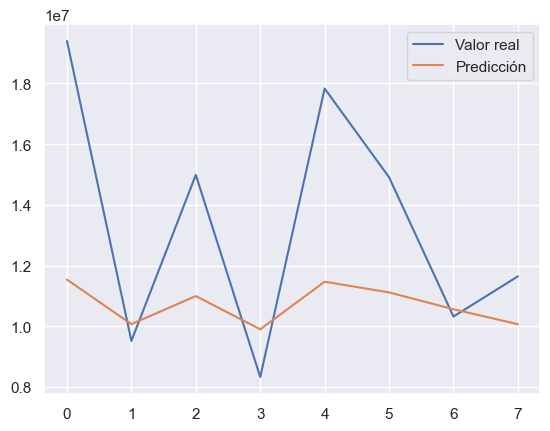

In [95]:
plt.plot(y_test, label='Valor real')
plt.plot(y_pred, label='Predicción')
plt.legend()
plt.show()

In [96]:
errorRNNM = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracyRNNM = 100 - errorRNNM
mseRNNM = np.mean((y_pred - y_test)**2)

In [97]:
print(f"Precision de la RNN por meses es: {accuracyRNNM}" )
print(f"El error es: {errorRNNM}")
print(f"El error cuadrático mse: {mseRNNM} kw")

Precision de la RNN por meses es: 78.90303774561079
El error es: 21.09696225438922
El error cuadrático mse: 17222930097611.746 kw


## RNN por horas

## RNN por días solo demanda

In [67]:
dataRNNdiasDemanda = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasDemanda), freq='D')
dataRNNdiasDemanda.index = date_index

# nuevo calculo

Epoch 1/50
23/23 [==============================] - 4s 35ms/step - loss: 0.2367 - val_loss: 0.3524
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1976 - val_loss: 0.2904
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1466 - val_loss: 0.1993
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0815 - val_loss: 0.0863
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0329 - val_loss: 0.0296
Epoch 6/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0252 - val_loss: 0.0251
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0203 - val_loss: 0.0199
Epoch 8/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 9/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0094
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 11/50
23/2

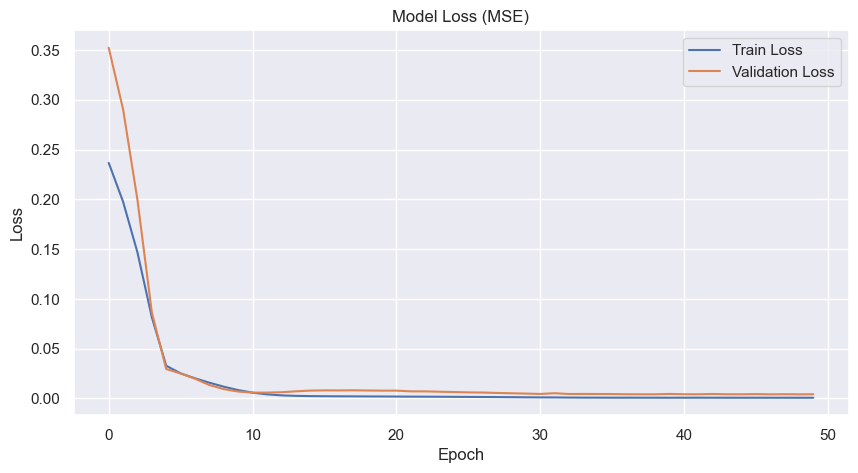

12/12 [==============================] - 0s 3ms/step
     Real Values  Predictions
0       0.396469     0.385824
1       0.398710     0.400796
2       0.394879     0.403146
3       0.403031     0.399132
4       0.398759     0.407660
..           ...          ...
359     0.466702     0.538823
360     0.432213     0.467812
361     0.411710     0.434955
362     0.334032     0.415751
363     0.419625     0.336973

[364 rows x 2 columns]


In [80]:
demand = dataRNNdiasDemanda[['Demanda']]
train_data = demand.loc['2019-01-01':'2020-12-31']
val_data = demand.loc['2021-01-01':'2021-12-31']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:i+1])
        y.append(data[i+1])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled)
X_val, y_val = prepare_data(val_scaled)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Visualizar el desempeño del entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Comparar las predicciones con los valores reales de 2021
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[1:].values, 'Predictions': predictions})

print(comparison)



In [87]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
threshold = 0.01
correct_predictions = np.abs(predictions - val_data['Demanda'].iloc[1:].values) <= threshold * val_data['Demanda'].iloc[1:].values
accuracy = np.mean(correct_predictions)

print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

 1/12 [=>............................] - ETA: 0s

12/12 [==============================] - 0s 4ms/step
Accuracy basado en un umbral del 1.0%: 14.01%


12/12 [==============================] - 0s 3ms/step


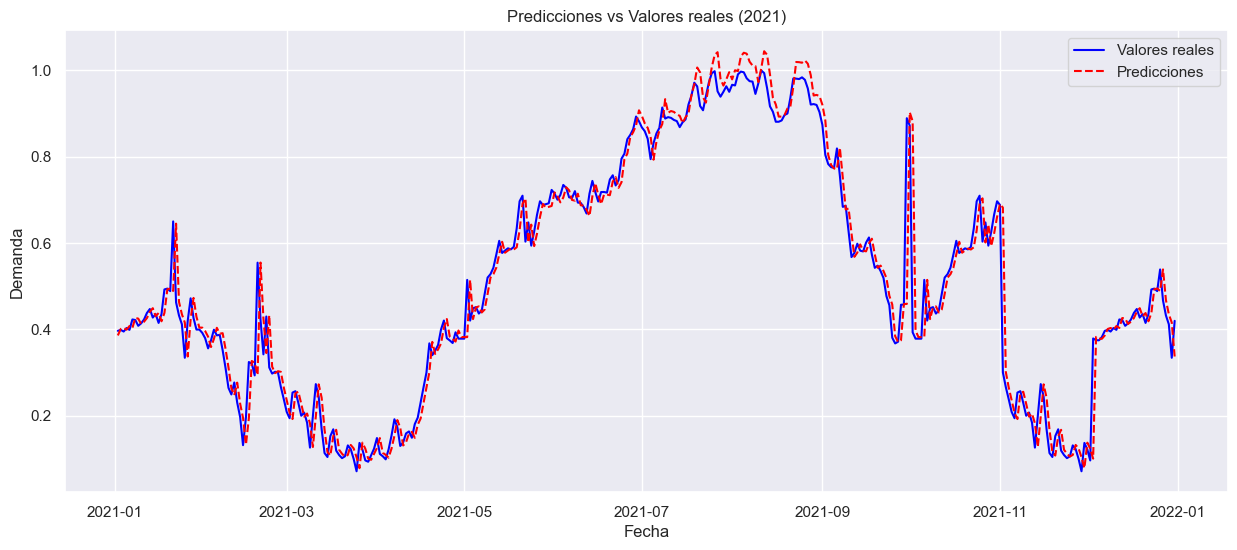

In [83]:

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[1:], val_data['Demanda'].iloc[1:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[1:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()

## RNN por días solo produccion

In [88]:
dataRNNdiasProduccion = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasProduccion), freq='D')
dataRNNdiasProduccion.index = date_index

Epoch 1/50
23/23 [==============================] - 6s 27ms/step - loss: 0.3760 - val_loss: 0.3869
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3223 - val_loss: 0.3216
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.2529 - val_loss: 0.2339
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.1618 - val_loss: 0.1241
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0666 - val_loss: 0.0399
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0283 - val_loss: 0.0283
Epoch 7/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0245 - val_loss: 0.0248
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.0212
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.0179
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 11/50
23/23 

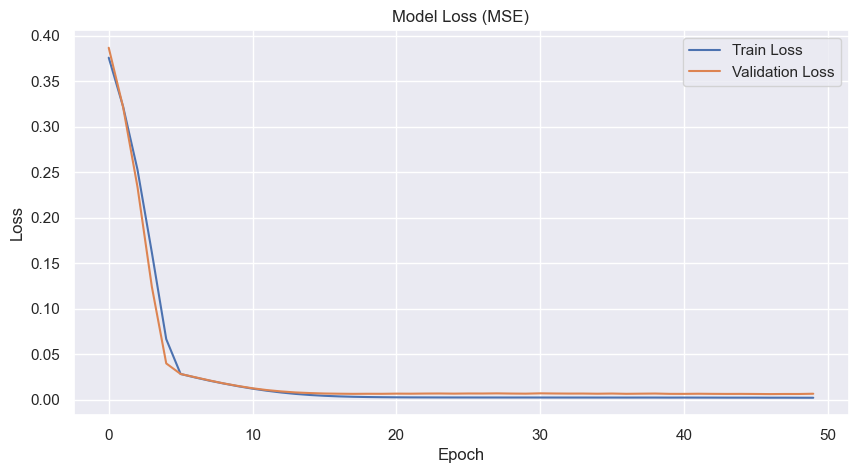

In [89]:
produccion = dataRNNdiasDemanda[['Produccion']]
train_data = produccion.loc['2019-01-01':'2020-12-31']
val_data = produccion.loc['2021-01-01':'2021-12-31']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:i+1])
        y.append(data[i+1])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled)
X_val, y_val = prepare_data(val_scaled)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Visualizar el desempeño del entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [90]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
comparison = pd.DataFrame({'Real Values': val_data['Produccion'].iloc[1:].values, 'Predictions': predictions})

print(comparison)

12/12 [==============================] - 1s 3ms/step
     Real Values    Predictions
0         253488  254220.393550
1         258897  256731.598157
2         259925  260541.469198
3         256563  261278.494002
4         256305  258883.521428
..           ...            ...
359       291977  293112.443942
360       279246  286453.406326
361       261122  275929.990420
362       248905  262141.974493
363       257533  253591.738064

[364 rows x 2 columns]


In [91]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
threshold = 0.01
correct_predictions = np.abs(predictions - val_data['Produccion'].iloc[1:].values) <= threshold * val_data['Produccion'].iloc[1:].values
accuracy = np.mean(correct_predictions)

print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

12/12 [==============================] - 0s 3ms/step
Accuracy basado en un umbral del 1.0%: 19.51%


12/12 [==============================] - 0s 3ms/step


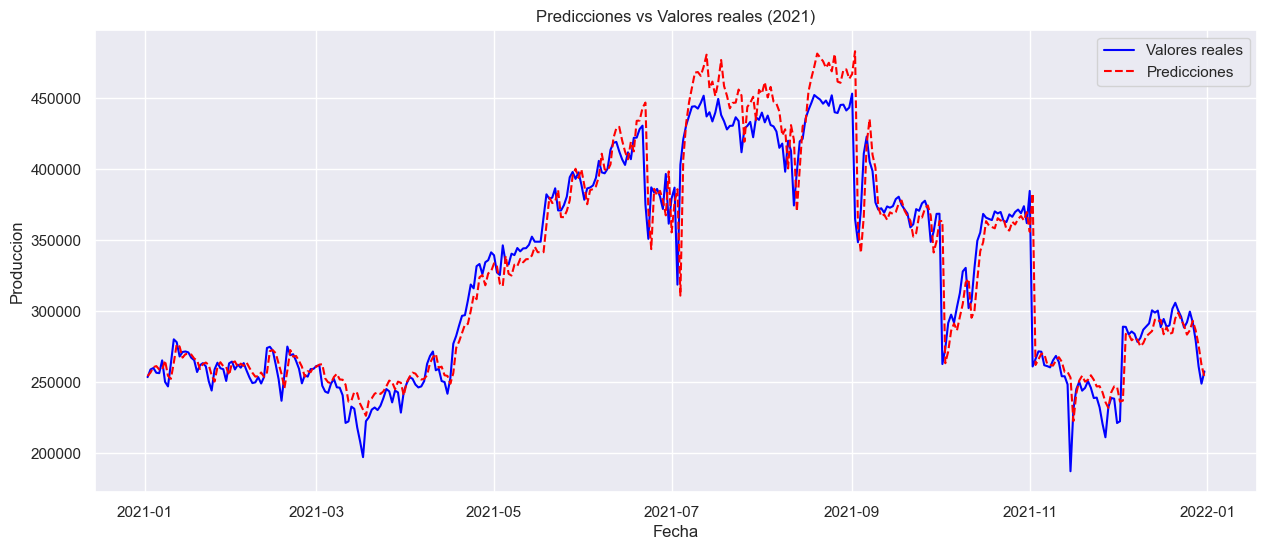

In [92]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[1:], val_data['Produccion'].iloc[1:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[1:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha")
plt.ylabel("Produccion")
plt.legend()
plt.grid(True)
plt.show()

## RNN por horas solo Demanda

In [176]:
dataHoraDemanda = pd.read_csv("datosHorarios.csv")

Epoch 1/50
549/549 [==============================] - 49s 9ms/step - loss: 0.0292 - mae: 0.1009 - val_loss: 0.0031 - val_mae: 0.0430
Epoch 2/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0015 - mae: 0.0299 - val_loss: 0.0018 - val_mae: 0.0354
Epoch 3/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 4/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0015 - val_mae: 0.0317
Epoch 5/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0015 - val_mae: 0.0330
Epoch 6/50
549/549 [==============================] - 3s 6ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 7/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 0.0015 - val_mae: 0.0332
Epoch 8/50
549/549 [==============================] - 3s 6ms/step - loss: 0

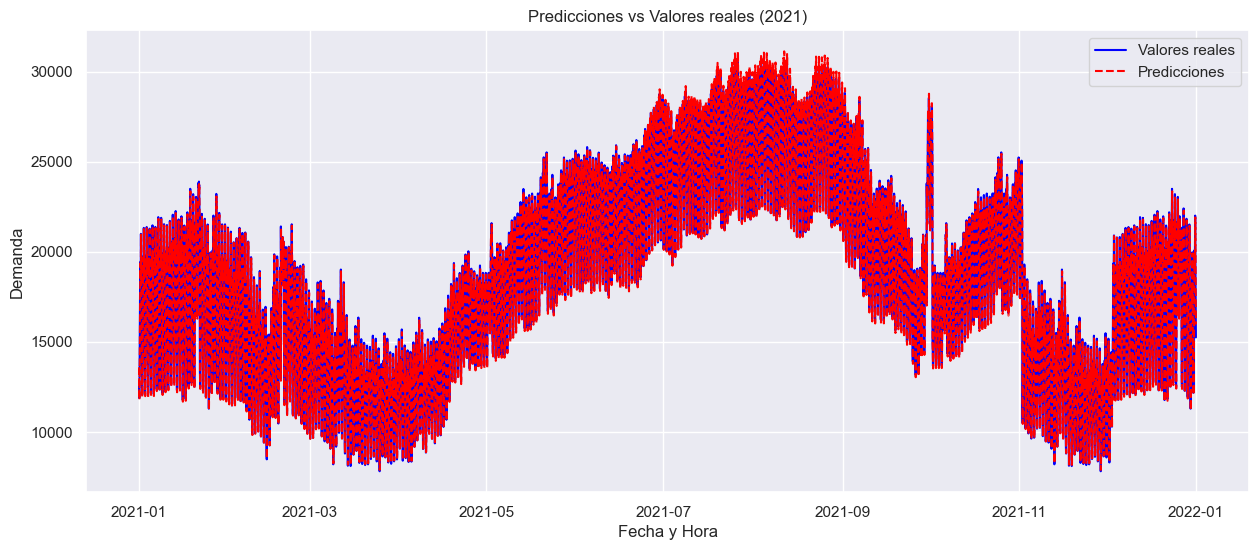

In [177]:

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraDemanda), freq='H')
dataHoraDemanda.index = date_hour_index

# Extraer solo la columna de demanda
demand = dataHoraDemanda[['Demanda']]

# Separar los datos en entrenamiento y validación
train_data = demand.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = demand.loc['2021-01-01':'2021-12-31 23:00:00']

# Escalar los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

# Preparar los datos para la LSTM
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:i+1])
        y.append(data[i+1])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled)
X_val, y_val = prepare_data(val_scaled)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Comparar las predicciones con los valores reales de 2021
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[1:], val_data['Demanda'].iloc[1:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[1:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


In [182]:
# Generar predicciones para el conjunto de validación
predictions = model.predict(X_val)

# Desescalar las predicciones para que estén en la escala original
predictions = scaler.inverse_transform(predictions)

# Crear un DataFrame para comparar los valores reales con las predicciones
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[1:].values, 'Predictions': predictions.flatten()})
print(comparison)

# Calcular el "accuracy" basado en un umbral
threshold = 0.02  # 1% del valor real
correct_predictions = np.abs(predictions.flatten() - val_data['Demanda'].iloc[1:].values) <= threshold * val_data['Demanda'].iloc[1:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


274/274 [==============================] - 1s 3ms/step
      Real Values   Predictions
0           12559  13591.078125
1           11928  12447.388672
2           11879  11833.079102
3           12429  11785.491211
4           13359  12320.598633
...           ...           ...
8754        19597  20737.388672
8755        18253  19522.207031
8756        17179  18134.429688
8757        16117  17039.414062
8758        15250  15967.745117

[8759 rows x 2 columns]
Accuracy basado en un umbral del 2.0%: 24.68%


## RNN por horas solo Produccion


In [184]:
dataHoraProduccion = pd.read_csv("datosHorarios.csv")

Epoch 1/50
549/549 [==============================] - 11s 9ms/step - loss: 0.0451 - mae: 0.1183 - val_loss: 0.0015 - val_mae: 0.0281
Epoch 2/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0015 - mae: 0.0282 - val_loss: 0.0015 - val_mae: 0.0277
Epoch 3/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0014 - mae: 0.0270 - val_loss: 0.0013 - val_mae: 0.0247
Epoch 4/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 0.0010 - val_mae: 0.0207
Epoch 5/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0011 - mae: 0.0235 - val_loss: 9.8832e-04 - val_mae: 0.0195
Epoch 6/50
549/549 [==============================] - 4s 6ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 9.5874e-04 - val_mae: 0.0191
Epoch 7/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 9.3504e-04 - val_mae: 0.0185
Epoch 8/50
549/549 [==============================] - 4s 7ms/st

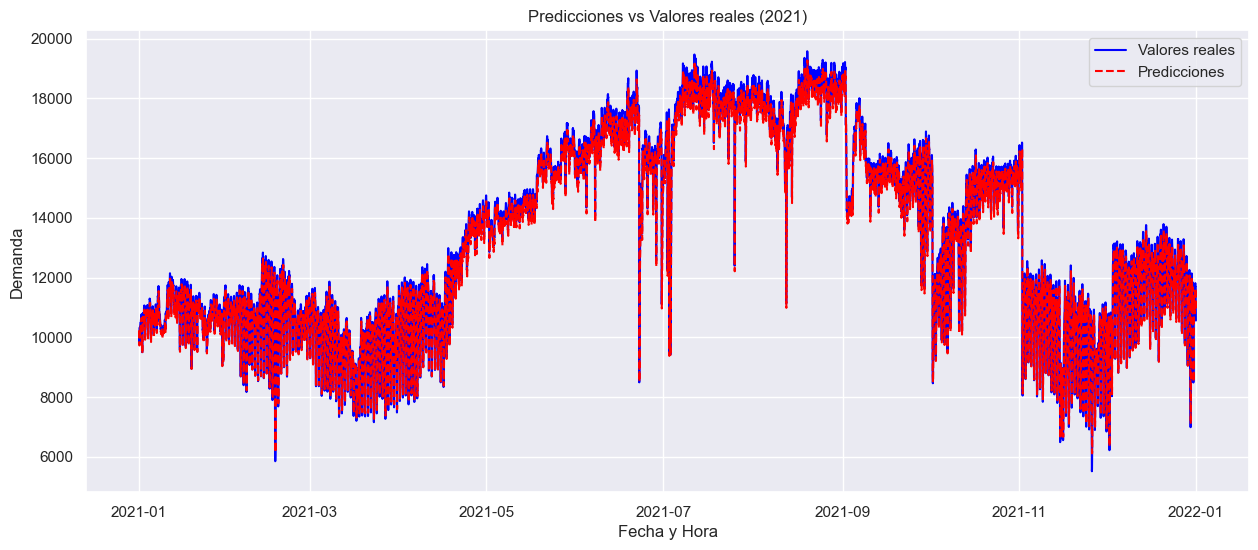

In [186]:

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraProduccion), freq='H')
dataHoraProduccion.index = date_hour_index

# Extraer solo la columna de demanda
produccion = dataHoraProduccion[['Produccion']]

# Separar los datos en entrenamiento y validación
train_data = produccion.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = produccion.loc['2021-01-01':'2021-12-31 23:00:00']

# Escalar los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

# Preparar los datos para la LSTM
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:i+1])
        y.append(data[i+1])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled)
X_val, y_val = prepare_data(val_scaled)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Comparar las predicciones con los valores reales de 2021
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[1:], val_data['Produccion'].iloc[1:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[1:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


In [187]:
# Generar predicciones para el conjunto de validación
predictions = model.predict(X_val)

# Desescalar las predicciones para que estén en la escala original
predictions = scaler.inverse_transform(predictions)

# Crear un DataFrame para comparar los valores reales con las predicciones
comparison = pd.DataFrame({'Real Values': val_data['Produccion'].iloc[1:].values, 'Predictions': predictions.flatten()})
print(comparison)

# Calcular el "accuracy" basado en un umbral
threshold = 0.02  # 1% del valor real
correct_predictions = np.abs(predictions.flatten() - val_data['Produccion'].iloc[1:].values) <= threshold * val_data['Produccion'].iloc[1:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


274/274 [==============================] - 1s 3ms/step
      Real Values   Predictions
0           10085  10233.565430
1            9865  10000.820312
2            9792   9793.608398
3            9938   9725.045898
4           10247   9862.266602
...           ...           ...
8754        11690  11639.442383
8755        11691  11522.069336
8756        11472  11523.030273
8757        11025  11313.072266
8758        10560  10887.479492

[8759 rows x 2 columns]
Accuracy basado en un umbral del 2.0%: 59.90%


## Predicción según meses

In [93]:
dataPredMes = data.copy()
dataPredMes

NameError: name 'data' is not defined

In [111]:
data1_19_20 = dataPredMes[(dataPredMes.index.month == 4) & (dataPredMes.index.year <= 2020)]
data1_21 = dataPredMes[(dataPredMes.index.month == 1) & (dataPredMes.index.year == 2021)]

In [112]:
train_data  = data1_19_20
train_data = train_data.drop('Produccion', axis=1)
train_data

,Demanda
fecha,
2019-04-01,286390
2019-04-02,283185
2019-04-03,281100
2019-04-04,273165
2019-04-05,270548
2019-04-06,273851
2019-04-07,276671
2019-04-08,274952
2019-04-09,273243


In [113]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

In [114]:
timesteps = 62

In [115]:

def create_sequences(data):
    X, y = [], []
    for i in range(len(data)-timesteps-1):
        X.append(data[i:(i+timesteps), 0])
        y.append(data[(i+timesteps), 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [116]:
X_train, y_train = create_sequences(train_data_scaled)

In [118]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

IndexError: tuple index out of range

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
1/1 - 3s - loss: 0.1555 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 0.1361 - 20ms/epoch - 20ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1191 - 22ms/epoch - 22ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1042 - 21ms/epoch - 21ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0912 - 23ms/epoch - 23ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0802 - 20ms/epoch - 20ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0714 - 18ms/epoch - 18ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0650 - 18ms/epoch - 18ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0615 - 20ms/epoch - 20ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0613 - 18ms/epoch - 18ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0641 - 19ms/epoch - 19ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0676 - 16ms/epoch - 16ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0693 - 19ms/epoch - 19ms/step
Epoch 14/100
1/1 - 0s - loss: 0.0686 - 15ms/epoch - 15ms/step
Epoch 15/100
1/1 - 0s - loss: 0.0663 - 17ms/epoch - 17ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0636 - 16ms/epoch - 16ms/step
Epoch 17/100
1/1 - 0s

In [ ]:
last_data = train_data_scaled[-timesteps:]
pred_values = []
for i in range(31):
    test_data_seq = last_data[-timesteps:]
    test_data_seq = test_data_seq.reshape(1, timesteps, 1)
    pred = model.predict(test_data_seq)
    pred_values.append(pred[0][0])
    last_data = np.append(last_data, pred)[1:]

1/1 [==============================] - 0s 23ms/step


In [ ]:
pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))

In [ ]:
for i, value in enumerate(pred_values):
    print("La demanda para el día", i+1, "de enero de 2021 es:", value[0])

La demanda para el día 1 de enero de 2021 es: 258554.78
La demanda para el día 2 de enero de 2021 es: 257502.66
La demanda para el día 3 de enero de 2021 es: 256607.48
La demanda para el día 4 de enero de 2021 es: 255845.81
La demanda para el día 5 de enero de 2021 es: 255237.47
La demanda para el día 6 de enero de 2021 es: 254766.58
La demanda para el día 7 de enero de 2021 es: 254438.48
La demanda para el día 8 de enero de 2021 es: 254229.55
La demanda para el día 9 de enero de 2021 es: 254029.19
La demanda para el día 10 de enero de 2021 es: 253864.6
La demanda para el día 11 de enero de 2021 es: 253758.48
La demanda para el día 12 de enero de 2021 es: 253696.56
La demanda para el día 13 de enero de 2021 es: 253666.06
La demanda para el día 14 de enero de 2021 es: 253645.9
La demanda para el día 15 de enero de 2021 es: 253640.44
La demanda para el día 16 de enero de 2021 es: 253615.64
La demanda para el día 17 de enero de 2021 es: 253594.44
La demanda para el día 18 de enero de 2021

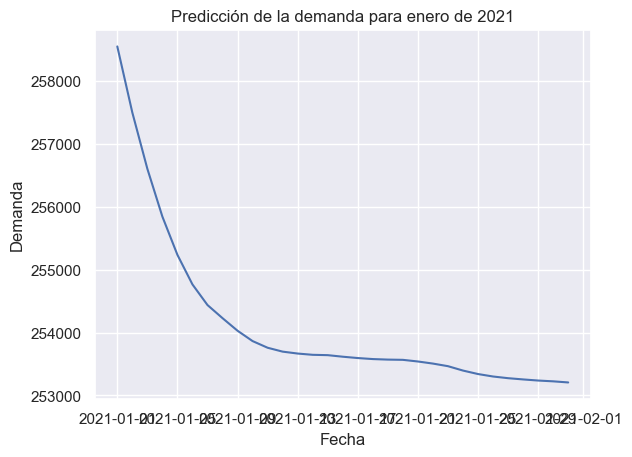

In [ ]:
fechas = [datetime.date(2021, 1, i+1) for i in range(len(pred_values))]
plt.plot(fechas, pred_values)
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Predicción de la demanda para enero de 2021')
plt.show()

In [ ]:
def demanda_segun_mes(mes,look_back):
    data1_19_20 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year <= 2020)]
    train_data  = data1_19_20.copy()
    train_data = train_data.drop('Produccion', axis=1)
    train_data
    data1_21 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year == 2021)]
    val_data  = data1_21.copy()
    val_data  = val_data .drop('Produccion', axis=1)
    val_data 
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    X, y = [], []
    for i in range(len(train_data_scaled)-timesteps-1):
        X.append(train_data_scaled[i:(i+timesteps), 0])
        y.append(train_data_scaled[(i+timesteps), 0])
    X_train = np.array(X)
    y_train = np.array(y)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(timesteps, 1), return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)
    last_data = train_data_scaled[-look_back:]
    pred_values = []
    for i in range(look_back):
        test_data_seq = last_data[-look_back:]
        test_data_seq = test_data_seq.reshape(1, look_back, 1)
        pred = model.predict(test_data_seq)
        pred_values.append(pred[0][0])
        last_data = np.append(last_data, pred)[1:]
    pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))
    fechas = [datetime.date(2021, mes, i+1) for i in range(len(pred_values))]
    plt.plot(fechas, pred_values, label='Predicho')
    plt.plot(fechas, val_data, label='Real')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()


    return pred_values

Epoch 1/100
1/1 - 5s - loss: 0.3730 - 5s/epoch - 5s/step
Epoch 2/100
1/1 - 0s - loss: 0.2716 - 63ms/epoch - 63ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1903 - 57ms/epoch - 57ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1299 - 52ms/epoch - 52ms/step
Epoch 5/100
1/1 - 0s - loss: 0.1052 - 48ms/epoch - 48ms/step
Epoch 6/100
1/1 - 0s - loss: 0.1311 - 51ms/epoch - 51ms/step
Epoch 7/100
1/1 - 0s - loss: 0.1402 - 51ms/epoch - 51ms/step
Epoch 8/100
1/1 - 0s - loss: 0.1227 - 53ms/epoch - 53ms/step
Epoch 9/100
1/1 - 0s - loss: 0.1048 - 55ms/epoch - 55ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0963 - 47ms/epoch - 47ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0954 - 46ms/epoch - 46ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0978 - 47ms/epoch - 47ms/step
Epoch 13/100
1/1 - 0s - loss: 0.1003 - 47ms/epoch - 47ms/step
Epoch 14/100
1/1 - 0s - loss: 0.1012 - 50ms/epoch - 50ms/step
Epoch 15/100
1/1 - 0s - loss: 0.1002 - 50ms/epoch - 50ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0976 - 48ms/epoch - 48ms/step
Epoch 17/100
1/1 - 0s

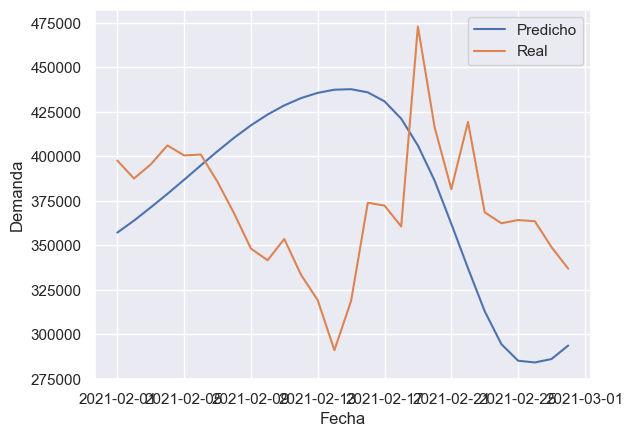

array([[357156.97],
       [363914.12],
       [371325.03],
       [378913.44],
       [386857.53],
       [394952.06],
       [402900.56],
       [410503.  ],
       [417445.22],
       [423524.1 ],
       [428666.94],
       [432750.53],
       [435696.28],
       [437478.  ],
       [437764.16],
       [435987.12],
       [430956.53],
       [421189.16],
       [406128.66],
       [386391.4 ],
       [362131.47],
       [337141.56],
       [312984.22],
       [294472.34],
       [285173.06],
       [284202.  ],
       [286113.47],
       [293704.72]], dtype=float32)

In [ ]:
demanda_segun_mes(2,28)

In [ ]:

def demanda_segun_mes2(mes, look_back):
    data1_19_20 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year <= 2020)]
    train_data = data1_19_20.drop('Produccion', axis=1)
    
    data1_21 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year == 2021)]
    val_data = data1_21.drop('Produccion', axis=1)
    
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    
    X_train, y_train = [], []
    for i in range(len(train_data_scaled) - look_back - 1):
        X_train.append(train_data_scaled[i:(i + look_back), 0])
        y_train.append(train_data_scaled[(i + look_back), 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    layers = 1
    units = 128
    return_sequence = False
    recurrent_dropout = 0
    dense_dropout = 0.2
    dense_layers = [32, 64, 128]

    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=return_sequence, recurrent_dropout=recurrent_dropout))
    for i in range(layers - 1):
        model.add(LSTM(units, return_sequences=return_sequence, recurrent_dropout=recurrent_dropout))
    for i in dense_layers:
        model.add(Dense(i, activation='relu'))
        model.add(Dropout(dense_dropout))
    model.add(Dense(1))

    optimizer = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    batch_size = 64
    epochs = 200
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    last_data = train_data_scaled[-look_back:]
    pred_values = []
    for i in range(len(val_data)):
        test_data_seq = last_data[-look_back:]
        test_data_seq = test_data_seq.reshape(1, look_back, 1)
        pred = model.predict(test_data_seq)
        pred_values.append(pred[0][0])
        last_data = np.append(last_data, pred)[1:]
    pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))
    fechas = [datetime.date(2021, mes, i+1) for i in range(len(pred_values))]
    plt.plot(fechas, pred_values, label='Predicho')
    plt.plot(val_data.index, val_data['Demanda'], label='Real')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()

    return pred_values


Epoch 1/200
1/1 - 3s - loss: 0.3570 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 0.3339 - 34ms/epoch - 34ms/step
Epoch 3/200
1/1 - 0s - loss: 0.2953 - 38ms/epoch - 38ms/step
Epoch 4/200
1/1 - 0s - loss: 0.2564 - 37ms/epoch - 37ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2290 - 35ms/epoch - 35ms/step
Epoch 6/200
1/1 - 0s - loss: 0.1873 - 34ms/epoch - 34ms/step
Epoch 7/200
1/1 - 0s - loss: 0.1458 - 36ms/epoch - 36ms/step
Epoch 8/200
1/1 - 0s - loss: 0.1373 - 34ms/epoch - 34ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0997 - 37ms/epoch - 37ms/step
Epoch 10/200
1/1 - 0s - loss: 0.1103 - 37ms/epoch - 37ms/step
Epoch 11/200
1/1 - 0s - loss: 0.1543 - 35ms/epoch - 35ms/step
Epoch 12/200
1/1 - 0s - loss: 0.1455 - 43ms/epoch - 43ms/step
Epoch 13/200
1/1 - 0s - loss: 0.1022 - 32ms/epoch - 32ms/step
Epoch 14/200
1/1 - 0s - loss: 0.1076 - 30ms/epoch - 30ms/step
Epoch 15/200
1/1 - 0s - loss: 0.0927 - 31ms/epoch - 31ms/step
Epoch 16/200
1/1 - 0s - loss: 0.1012 - 38ms/epoch - 38ms/step
Epoch 17/200
1/1 - 0s

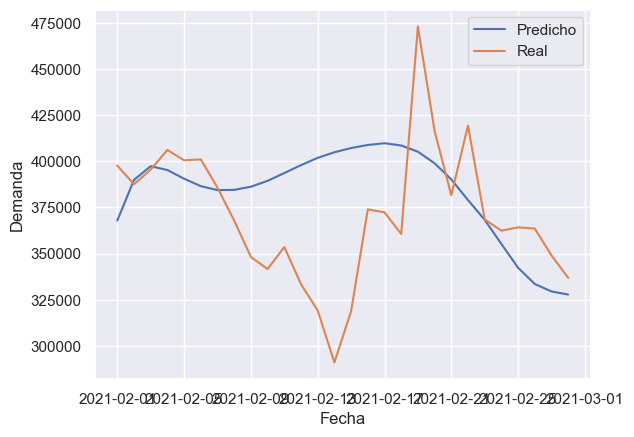

array([[367924.47],
       [389946.7 ],
       [397349.03],
       [395276.38],
       [390564.6 ],
       [386556.2 ],
       [384395.1 ],
       [384531.62],
       [386243.72],
       [389421.7 ],
       [393630.4 ],
       [397942.25],
       [401870.72],
       [404898.1 ],
       [407188.2 ],
       [408839.5 ],
       [409799.8 ],
       [408577.  ],
       [405196.12],
       [398946.5 ],
       [390177.5 ],
       [379021.66],
       [368295.53],
       [355223.12],
       [342360.8 ],
       [333547.38],
       [329540.66],
       [327840.78]], dtype=float32)

In [ ]:
demanda_segun_mes2(2, 28)